### NFL inference and simulation with `turf`

---

This notebook runs a hierarchical Bayesian inference model on 2024 NFL season results to estimate team offensive and defensive strengths, visualize the results, and simulate game outcomes.

David Fleming, 2024

In [1]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
from turf import scrape, utils, inference

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

**Initiate and fit model**

---


In [2]:
# Pull season results to-date
season = scrape.NFLSeason(year=2024)

In [3]:
# Initialize model
model = inference.IndependentNegativeBinomialMixture(season)

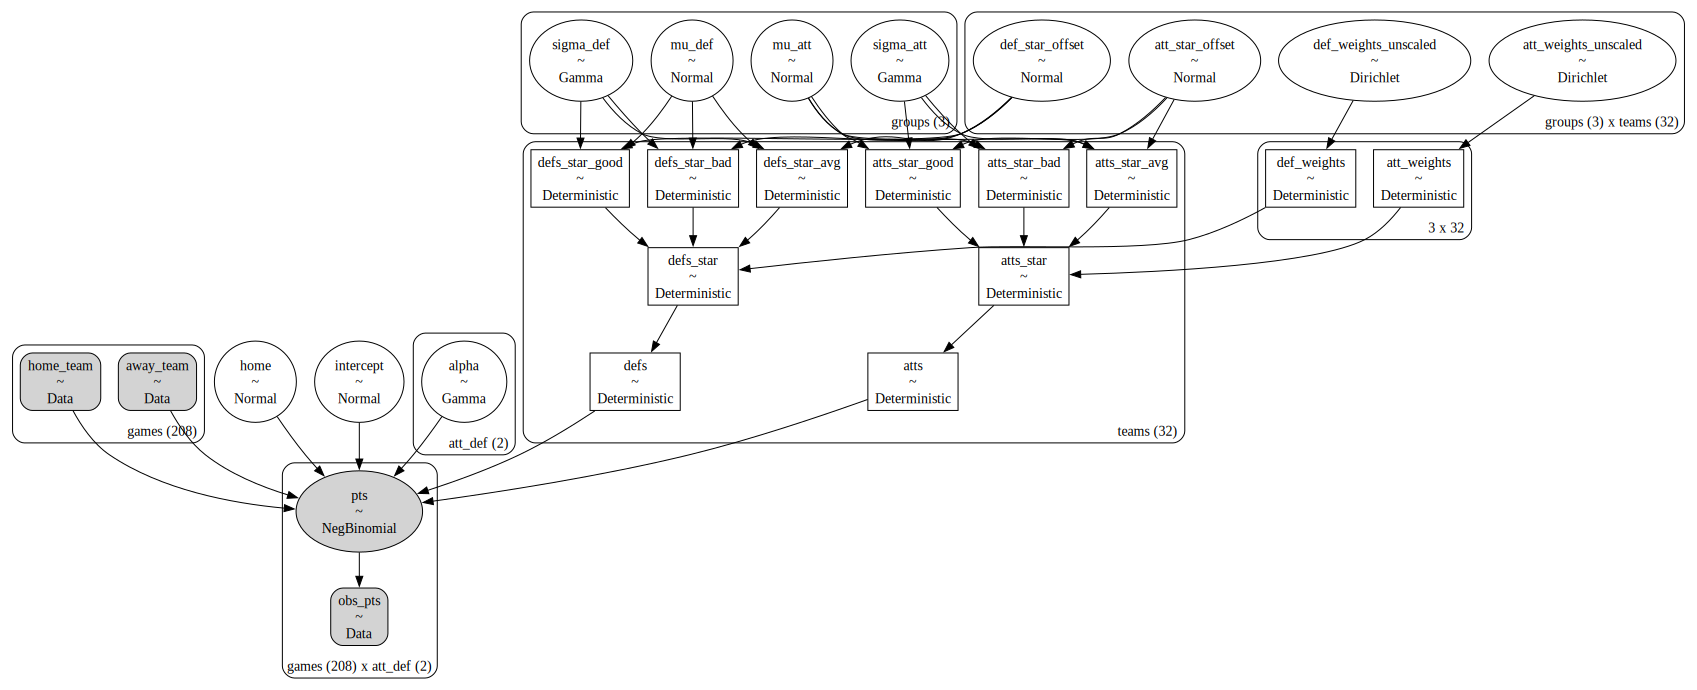

In [4]:
# Visualize model
pm.model_graph.model_to_graphviz(model.model)

In [5]:
# Run inference on 4 cores (1 chain per core)
model.run_inference(tune=2000, draws=1000, target_accept=0.95, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [home, intercept, att_weights_unscaled, def_weights_unscaled, mu_att, mu_def, sigma_att, sigma_def, alpha, att_star_offset, def_star_offset]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 121 seconds.


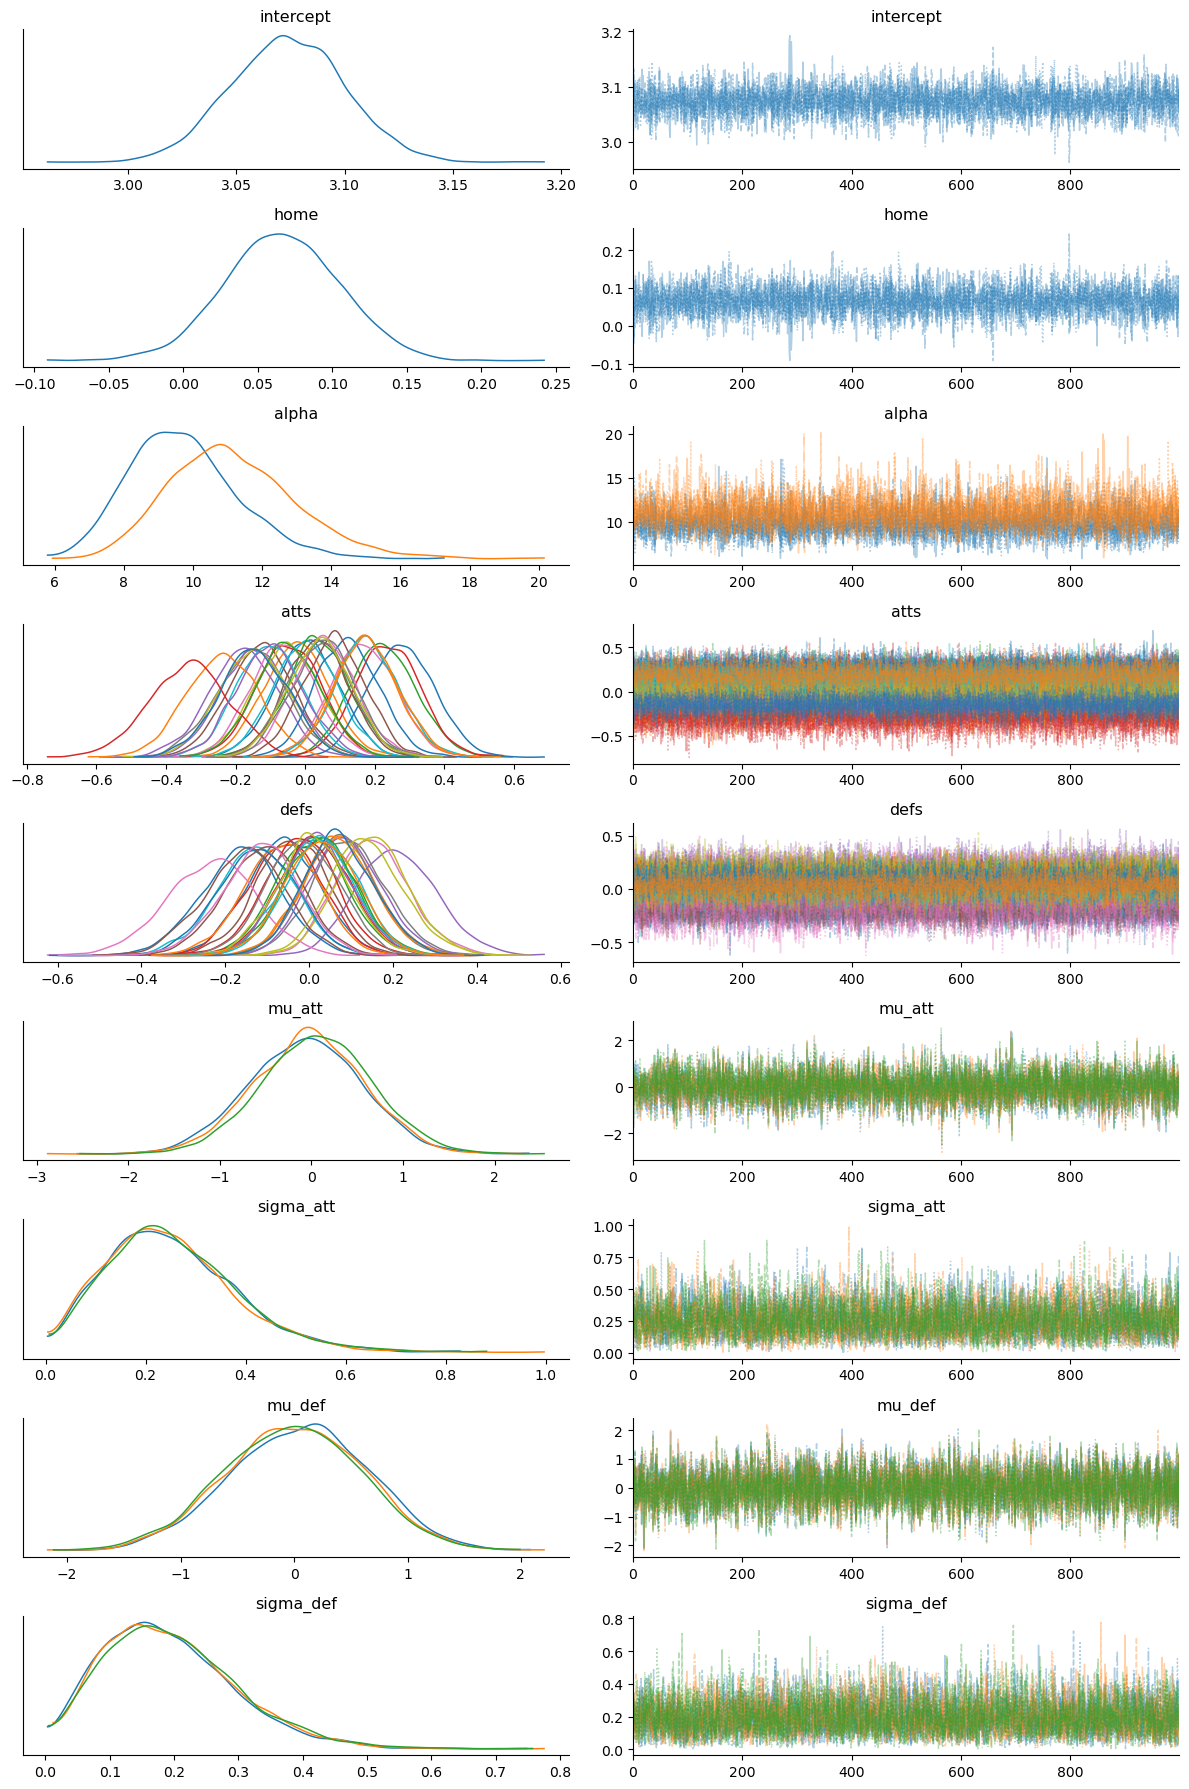

In [6]:
# Examine full posterior distributions and trace for select parameters
axes = az.plot_trace(model.trace_, compact=True, var_names=["intercept", "home", "alpha",
                                                            "atts", "defs", "mu_att", "sigma_att",
                                                            "mu_def", "sigma_def"],
                     combined=True)

for ii in range(axes.shape[0]):
    for jj in range(axes.shape[1]):
        ax = axes[ii,jj]
        sns.despine(ax=ax)
ax.get_figure().tight_layout()

In [7]:
# Examine MCMC statistics to check convergence
az.summary(model.trace_, group='posterior', var_names=['mu'], filter_vars='like')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_att[bad],-0.065,0.618,-1.247,1.043,0.012,0.009,2793.0,2861.0,1.0
mu_att[average],-0.026,0.604,-1.093,1.155,0.011,0.009,3303.0,3465.0,1.0
mu_att[good],0.060,0.605,-1.133,1.125,0.011,0.009,3188.0,3253.0,1.0
mu_def[bad],0.055,0.605,-1.098,1.159,0.010,0.009,3661.0,3168.0,1.0
mu_def[average],0.006,0.602,-1.170,1.071,0.010,0.009,3789.0,3173.0,1.0
mu_def[good],-0.024,0.608,-1.189,1.093,0.010,0.009,3661.0,2991.0,1.0


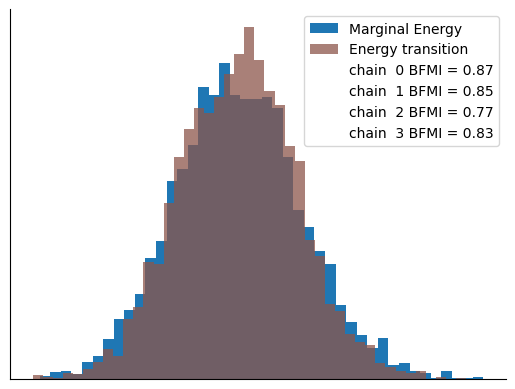

In [8]:
# Same as above, but visualizing energy of chain transition
# Should be ~1 for good convergence
ax = az.plot_energy(model.trace_, kind='hist')
sns.despine(ax=ax)

In [9]:
# Team names, medians, CIs, and colors
team_names = model.trace_.posterior.coords['teams'].values

# Calculate median, 68% CI for atts, defs for each team
med_atts = model.trace_.posterior["atts"].median(axis=1).median(axis=0).values
med_defs = model.trace_.posterior["defs"].median(axis=1).median(axis=0).values

# Calculate median, 68% CI for atts, defs for each team, convert to numpy arrays
defs_CI = az.hdi(model.trace_, var_names=["defs"], hdi_prob=0.68)
defs_CI = defs_CI.to_array().values[0]

atts_CI = az.hdi(model.trace_, var_names=["atts"], hdi_prob=0.68)
atts_CI = atts_CI.to_array().values[0]

# Get primary and secondary colors for pretty plots
pri_colors = list(map(lambda x : utils._hex_color_nfl[f"{x}_0"], team_names))
sec_colors = list(map(lambda x : utils._hex_color_nfl[f"{x}_1"], team_names))

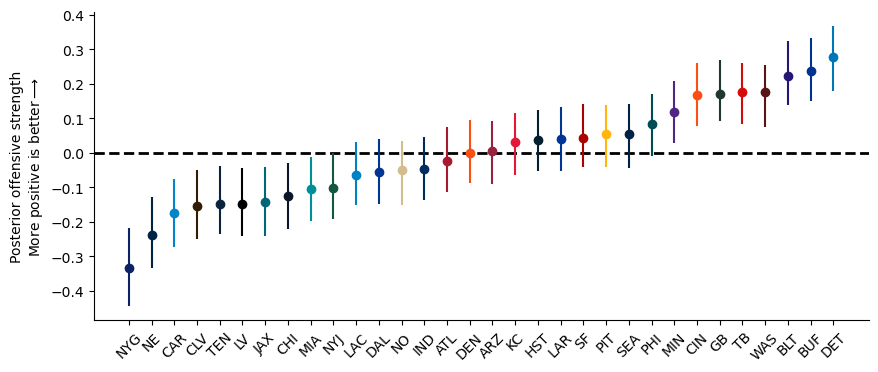

In [10]:
# Plot ordered attacking strength
fig, ax = plt.subplots(figsize=(10,4))

# Order values by worst to best attacking
inds = np.argsort(med_atts)

x = np.arange(len(med_atts))
for ii in range(len(x)):
    ax.errorbar(x[ii], med_atts[inds[ii]], 
                yerr=np.asarray([med_atts[inds[ii]] - atts_CI[inds[ii],0], atts_CI[inds[ii],1] - med_atts[inds[ii]]]).reshape(2,1),
                fmt='o', color=pri_colors[inds[ii]])

ax.axhline(0, lw=2, ls="--", color="k", zorder=0)
ax.set_xlabel('')
ax.set_ylabel('Posterior offensive strength\n' + r'More positive is better$\longrightarrow$')
_ = ax.set_xticks(x)
_ = ax.set_xticklabels(model._coords["teams"][inds], rotation=45)
sns.despine(ax=ax)

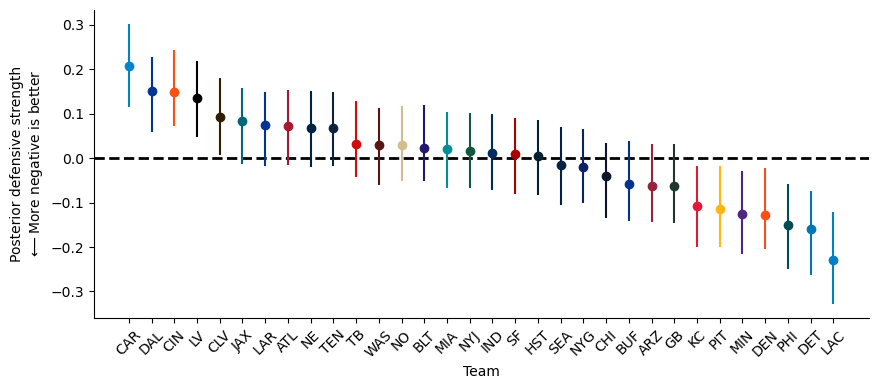

In [11]:
# Plot ordered attacking strength
fig, ax = plt.subplots(figsize=(10,4))

# Order values by worst to best attacking
inds = np.argsort(med_defs)[::-1]

x = np.arange(len(med_defs))
for ii in range(len(x)):
    ax.errorbar(x[ii], med_defs[inds[ii]], 
                yerr=np.asarray([med_defs[inds[ii]] - defs_CI[inds[ii],0], defs_CI[inds[ii],1] - med_defs[inds[ii]]]).reshape(2,1),
                fmt='o', color=pri_colors[inds[ii]])

ax.axhline(0, lw=2, ls="--", color="k", zorder=0)
ax.set_xlabel('Team')
ax.set_ylabel('Posterior defensive strength\n' + r'$\longleftarrow$More negative is better')
_ = ax.set_xticks(x)
_ = ax.set_xticklabels(model._coords["teams"][inds], rotation=45)
sns.despine(ax=ax)

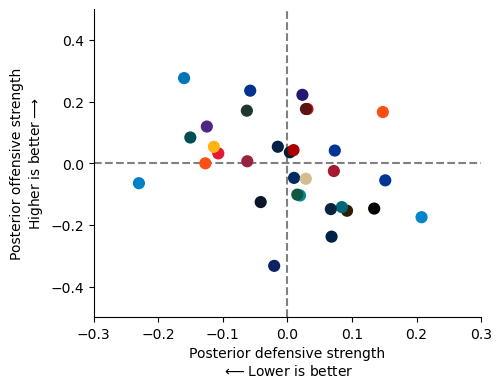

In [12]:
# Plot offensive and defensive strength together
fig, ax = plt.subplots(figsize=(5,4))

im = ax.scatter(med_defs, med_atts, s=60, zorder=1, c=pri_colors)
ax.axhline(0, lw=1.5, ls="--", color="grey", zorder=0)
ax.axvline(0, lw=1.5, ls="--", color="grey", zorder=0)

ax.set_xlabel('Posterior defensive strength\n' + r'$\longleftarrow$Lower is better')
ax.set_ylabel('Posterior offensive strength\n' + r'Higher is better$\longrightarrow$')
ax.set_xlim(-0.3, 0.3)
ax.set_ylim(-0.5, 0.5)
sns.despine(ax=ax)

**Simulate many games**

---

Simulate NFL results to estimate who will win, with what probability, and similar inferences for over/unders, moneyline, and spreads.

In [14]:
n_sims = 25000
away_teams = ["LAR"]
home_teams = ["SF"]
ous = [51.5]
ous_vegas = [-110]
home_spreads = [-3.5]
home_spreads_vegas = [100]
home_ml_vegas = [-190]

# Holders
totals = []
overs = []
covers = []
home_mls = []
home_pts_mean = []
away_pts_mean = []

for home_team, away_team, ou, hs, ii, in zip(home_teams, away_teams, ous, home_spreads, np.arange(len(home_teams))):

    # Simulate n game outcomes
    home_pts, away_pts, home_win, tie = model.simulate_game(home_team, away_team, n=n_sims, neutral_site=False)
    
    total = home_pts + away_pts
    odds = np.mean(total > ou)
    cover = np.mean(home_pts - away_pts > -hs)
    home_ml = np.mean(home_pts > away_pts)
    
    # Print, then cache, results
    print(f"---{away_team} at {home_team}---")
    print(f"O/U: {ou} - Over odds : {np.round(100*odds, decimals=2):.1f}%")
    print(f"Spread: {home_team} {home_spreads[ii]} - odds of {home_team} cover : {np.round(100*cover, decimals=2):.1f}%") 
    print(f"ML: - odds of {home_team} ML : {np.round(100*home_ml, decimals=2):.1f}%")
    print(f"Median scores: {away_team} {np.median(away_pts):.0f} | {home_team} {np.median(home_pts):.0f}")
    print()

---LAR at SF---
O/U: 51.5 - Over odds : 39.4%
Spread: SF -3.5 - odds of SF cover : 48.9%
ML: - odds of SF ML : 57.9%
Median scores: LAR 22 | SF 25



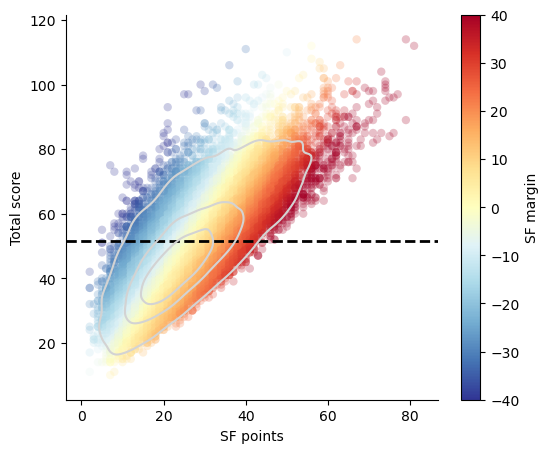

In [15]:
fig, ax = plt.subplots(figsize=(6,5))

ax.axhline(ous[0], ls="--", lw=2, color='k', zorder=1)
sc = ax.scatter(home_pts, home_pts + away_pts, c=home_pts - away_pts, 
                alpha=0.25, zorder=0, cmap="RdYlBu_r", edgecolor="None",
                vmin=-40, vmax=40)
sns.kdeplot(x=home_pts, y=home_pts + away_pts, ax=ax, levels=4, color='lightgrey', zorder=3)

cb = fig.colorbar(sc, label=f'{home_team} margin')
cb.solids.set(alpha=1)
ax.set_ylabel("Total score")
ax.set_xlabel(f"{home_team} points")
sns.despine(ax=ax)

**Examine posterior predictive distribution**

---

Simple model evaluation method to see if model can reproduce season total points distribution.

In [16]:
# Sample from posterior predictive distribution
with model.model:
    model.trace_.extend(pm.sample_posterior_predictive(model.trace_))

Sampling: [pts]


Output()

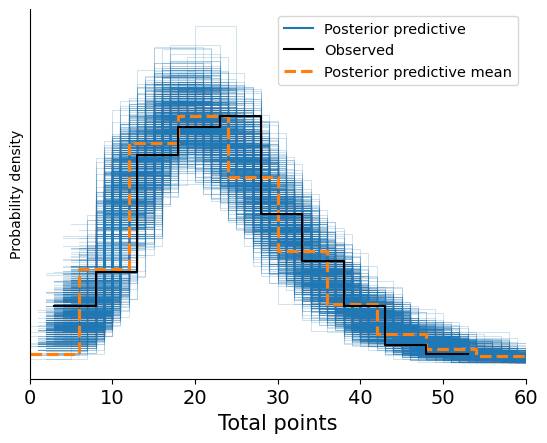

In [17]:
ax = az.plot_ppc(model.trace_, kind='kde', num_pp_samples=1000, group='posterior')
sns.despine(ax=ax)
ax.set_xlim(0, 60)
ax.set_xlabel("Total points")
ax.set_ylabel("Probability density");

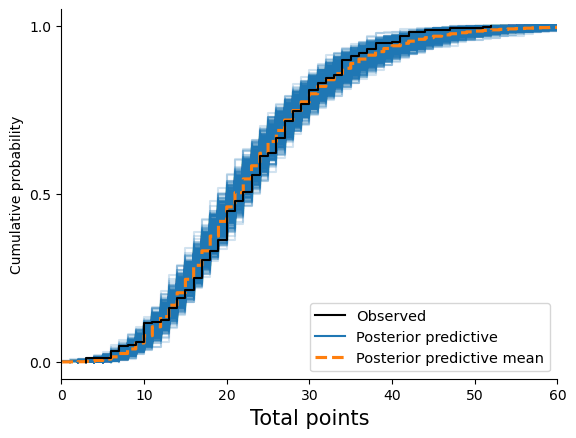

In [18]:
ax = az.plot_ppc(model.trace_, kind='cumulative', num_pp_samples=1000, group='posterior')
sns.despine(ax=ax)
ax.set_xlim(0, 60)
ax.set_xlabel("Total points")
ax.set_ylabel("Cumulative probability");

In [19]:
az.plot_ppc?

Signature:
az.plot_ppc(
    data,
    kind='kde',
    alpha=None,
    mean=True,
    observed=None,
    observed_rug=False,
    color=None,
    colors=None,
    grid=None,
    figsize=None,
    textsize=None,
    data_pairs=None,
    var_names=None,
    filter_vars=None,
    coords=None,
    flatten=None,
    flatten_pp=None,
    num_pp_samples=None,
    random_seed=None,
    jitter=None,
    animated=False,
    animation_kwargs=None,
    legend=True,
    labeller=None,
    ax=None,
    backend=None,
    backend_kwargs=None,
    group='posterior',
    show=None,
)
Docstring:
Plot for posterior/prior predictive checks.

Parameters
----------
data : InferenceData
    :class:`arviz.InferenceData` object containing the observed and posterior/prior
    predictive data.
kind : str, default "kde"
    Type of plot to display ("kde", "cumulative", or "scatter").
alpha : float, optional
    Opacity of posterior/prior predictive density curves.
    Defaults to 0.2 for ``kind = kde`` and cumulativ